In [127]:
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import matplotlib
matplotlib.use("Agg")
from matplotlib import pyplot as plt
from matplotlib import pylab #displays arrays as images for easy error checking
import numpy as np
import scipy as sp
import networkx as nx
from PIL import Image
from PIL import ImageDraw
import seaborn as sbn
#sbn.set_context("talk", font_scale=1)
from IPython.core.pylabtools import figsize
figsize(10, 6)


from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp


/Users/mplajer/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Functions for equivalent resistance calculation
def G_matrix(graph):
    """
    Using the data from the input networkx graph, returns
    the G matrix needed to complete the nodal analysis calculation.
    """
    # Find the reciprocal of resistance for each connection (i.e. each edge)
    for node1, node2 in graph.edges():
        graph[node1][node2]['reciprocalR'] = 1.0 / graph[node1][node2]['resistance']
    # The adjacency matrix gives all needed elements but the diagonal
    G = nx.adjacency_matrix(graph, weight='reciprocalR')
    # Add the diagonal
    G.setdiag(np.squeeze(np.asarray(-nx.incidence_matrix(graph, weight='reciprocalR').sum(axis=1))))
    # G is a csr_matrix, but we want an array
    return G.toarray()

def equivalent_resistance(graph, check_nodes):
    """
    Given a graph and a list of two check nodes,
    computes the equivalent resistance.
    """
    # Get the G matrix
    G = G_matrix(graph)
    I = np.zeros(len(G))
    I[check_nodes[0]] = 1.
    I[check_nodes[1]] = -1.
    
    # Solve for the voltage matrix
    try:
        V = np.linalg.solve(G, I)
        
        # use a simple numpy operation to compute the equivalent resistance
        equivalent_resistance = abs(sum(I*V))
        return equivalent_resistance
    except:
        # if np.linalg.solve fails, raise an error
        print("Error: could not solve the matrix equation. Is the G-matrix singular?")
        raise

# credit to Bryce Boe http://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/
def ccw(ax, ay, bx, by, cx, cy):
    """
    Determines whether points a, b, and c are counerclockwise
    """
    return (cy - ay)*(bx - ax) > (by-ay)*(cx-ax)

def intersect(ax, ay, bx, by, cx, cy, dx, dy):
    """
    a and b describe one line segment; c and d describe another.
    """
    return (ccw(ax, ay, cx, cy, dx, dy) != ccw(bx, by, cx, cy, dx, dy) and
            ccw(ax, ay, bx, by, cx, cy) != ccw(ax, ay, bx, by, dx, dy))

def model(network_size,
         CNT_length_normal,
         CNT_length_stddev,
         CNT_num_tubes,
         resistance_mean,
         resistance_stddev):
    """
    Returns the equivalent resistance, given inputs of the size of the CNT film,
    and information about the tubes' size distribution.
    """
    #converting CNT_num_tubes to an integer so function doesn't break when the array
    #for sensitivity analysis is passed to it
    CNT_num_tubes = int(CNT_num_tubes)
    CNT_init = np.zeros((CNT_num_tubes+2,7))

    #creating the pseudo tubes that will act as the edges in the network
    CNT_init[0:2,:] = [[network_size,0,0,0,0,network_size,0],
                       [network_size,0,1,0,network_size,network_size,network_size]]
    
    #Generating tube information
    #randomly assigning tube lengths distributed around a set tube length
    logmean = np.log(CNT_length_normal / (np.sqrt(1+(CNT_length_stddev/CNT_length_normal)**2)))
    logstdev = np.sqrt(np.log(1+(CNT_length_stddev/CNT_length_normal)**2))
    CNT_init[2:,0] = np.random.lognormal(logmean, logstdev, CNT_num_tubes)

    #randomly assign starting point and orientation
    CNT_init[2:,1:4] = np.random.rand(CNT_num_tubes, 3)

    #applying scaling to random numbers so they match the needed values
    scaling_factor = np.array([1, network_size, network_size, 2*np.pi, 1, 1, 1])
    CNT_init = CNT_init * scaling_factor

    #calculating the x-max for the tubes
    CNT_init[:,5] = CNT_init[:,1] + np.cos(CNT_init[:,3]) * CNT_init[:,0]

    #calculating the y-max for the tubes
    CNT_init[:,6] = CNT_init[:,2] + np.sin(CNT_init[:,3]) * CNT_init[:,0]

    #calculating slope
    CNT_init[:,3] = np.tan(CNT_init[:,3])
    
    #calculating the y-intercept of the lines
    CNT_init[:,4] = CNT_init[:,2] - CNT_init[:,3] * CNT_init[:,2]

    #print CNT_init to file, indexing to the run number (hopefully)
    filename = "CNT_data_" + str(sampleindex) + ".npy"
    np.save(filename, CNT_init)
    
    #generating a boolean array of the tubes that intersect
    CNT_intersect = np.zeros((CNT_num_tubes+2,CNT_num_tubes+2),dtype=bool)
    
    for i,row1 in enumerate(CNT_init):
        for j,row2 in enumerate(CNT_init[i+1:,:]):
            coords = np.concatenate((row1[1:3], row1[5:7], row2[1:3], row2[5:7]))
            if intersect(*coords):
                CNT_intersect[i,j+i+1] = True
    
    #gives the indicies along the x-axis of the true values as the 
    #first array and the y-values as the second array
    CNT_tube_num1, CNT_tube_num2 = np.where(CNT_intersect)
    
    #add the intersections as edges in a networkx graph
    graph = nx.Graph()
    graph.add_edges_from((CNT_tube_num1[k], CNT_tube_num2[k],
                          {'resistance': np.random.normal(resistance_mean, resistance_stddev)})
                         for k in range(0, np.sum(CNT_intersect)))
    
    #get rid of any bits of the graph not contiguous with node 0 (one of the test nodes)
    #thanks to Pieter Swart from 2006 [https://groups.google.com/forum/#!topic/networkx-discuss/XmP5wZhrDMI]
    try:
        contiguous_nodes = nx.node_connected_component(graph, 0)
        new_graph = graph.subgraph(contiguous_nodes)
    except KeyError:
        print("Could not compute equivalent resistance; the starting tube has no intersections")
        path_exists = False
    
    #computes equiv. resistance
    try:
        path_exists = nx.has_path(new_graph, 0, 1)
    except:
        path_exists = False
    
    if path_exists:
        try:
            eqr = equivalent_resistance(new_graph,[0,1])
        except:
            eqr = np.nan
    else:
        print("Could not compute equivalent resistance; there is no contiguous path through the network.")
        eqr = np.nan
 
    return eqr


## read the six parameters from the input file
#
## run the model:
#equivalent_resistance = model(network_size, CNT_length_normal, CNT_length_stddev,
#                                CNT_num_tubes, resistance_mean, resistance_stddev)
#
## save the model output
#
## (unfinished)
#
#
##Important variables
#network_size = 10 #side length of network boundaries
#CNT_length_normal = 445 #normal length of CNT at center of distribution
#CNT_length_stddev = 310 #standard deviation of CNT length from normal
#CNT_num_tubes = 1000 #number of tubes in film
#resistance_mean = 10
#resistance_stddev = 1

In [3]:
#Defining the problem
morris_problem = {
    # There are six variables
    'num_vars': 6,
    # These are their names
    'names': ['network_size', 'CNT_length_normal', 'CNT_length_stddev', 'CNT_num_tubes', 'resistance_mean', 'resistance_stddev'],
    # These are their plausible ranges over which we'll move the variables
    'bounds': [[1000, 10000], # network size (nm)
               [100, 1000], # length that tubes are distributed around (nm)
               [100, 500], # standard deviation of tube length (nm)
               [100, 5000], # number of tubes in network
               [1, 100], # mean contact resistance of tubes (Ω)
               [1, 20], # standard deviation of contact resistance (Ω)
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

In [4]:
num_levels = 50
grid_jump = 2
sample = ms.sample(morris_problem, 1000, num_levels, grid_jump)
#forcing the number of tubes to be an integer so no errors are thrown
#sample[:,3] = np.around(sample[:,3])

In [5]:
print(sample.shape)
print(sample)

(7000, 6)
[[  7.61224490e+03   4.85714286e+02   1.81632653e+02   8.00000000e+02
    2.32244898e+01   1.53469388e+01]
 [  7.61224490e+03   4.85714286e+02   1.81632653e+02   1.00000000e+03
    2.32244898e+01   1.53469388e+01]
 [  7.61224490e+03   4.85714286e+02   1.97959184e+02   1.00000000e+03
    2.32244898e+01   1.53469388e+01]
 ..., 
 [  4.85714286e+03   8.89795918e+02   1.73469388e+02   4.80000000e+03
    8.18163265e+01   5.26530612e+00]
 [  4.85714286e+03   8.89795918e+02   1.73469388e+02   4.80000000e+03
    8.58571429e+01   5.26530612e+00]
 [  4.85714286e+03   8.89795918e+02   1.73469388e+02   4.60000000e+03
    8.58571429e+01   5.26530612e+00]]


In [6]:
##run this to recreate error
#sample = np.load('sample_input_error.npy')
##shows the variables that will return the error
#print(sample.shape)
#print(sample)

In [7]:
print(sample.shape[0])
print(sample[0])
for row in sample:
    print(row)

7000
[ 7612.24489796   485.71428571   181.63265306   800.            23.2244898
    15.34693878]
[ 7612.24489796   485.71428571   181.63265306   800.            23.2244898
    15.34693878]
[ 7612.24489796   485.71428571   181.63265306  1000.            23.2244898
    15.34693878]
[ 7612.24489796   485.71428571   197.95918367  1000.            23.2244898
    15.34693878]
[ 7979.59183673   485.71428571   197.95918367  1000.            23.2244898
    15.34693878]
[ 7979.59183673   485.71428571   197.95918367  1000.            19.18367347
    15.34693878]
[ 7979.59183673   448.97959184   197.95918367  1000.            19.18367347
    15.34693878]
[ 7979.59183673   448.97959184   197.95918367  1000.            19.18367347
    14.57142857]
[  5.59183673e+03   2.83673469e+02   1.24489796e+02   1.90000000e+03
   5.55510204e+01   2.93877551e+00]
[  5.59183673e+03   2.83673469e+02   1.24489796e+02   1.90000000e+03
   5.55510204e+01   2.16326531e+00]
[  5.59183673e+03   2.83673469e+02   1.2448979

    16.89795918]
[ 8530.6122449    173.46938776   246.93877551   400.            53.53061224
    16.89795918]
[ 8530.6122449    173.46938776   246.93877551   200.            53.53061224
    16.89795918]
[ 8163.26530612   173.46938776   246.93877551   200.            53.53061224
    16.89795918]
[ 8163.26530612   173.46938776   246.93877551   200.            57.57142857
    16.89795918]
[  7.61224490e+03   1.00000000e+03   3.93877551e+02   4.80000000e+03
   1.00000000e+02   6.81632653e+00]
[  7.61224490e+03   1.00000000e+03   3.93877551e+02   5.00000000e+03
   1.00000000e+02   6.81632653e+00]
[  7.97959184e+03   1.00000000e+03   3.93877551e+02   5.00000000e+03
   1.00000000e+02   6.81632653e+00]
[  7.97959184e+03   1.00000000e+03   3.93877551e+02   5.00000000e+03
   1.00000000e+02   7.59183673e+00]
[  7.97959184e+03   1.00000000e+03   4.10204082e+02   5.00000000e+03
   1.00000000e+02   7.59183673e+00]
[  7.97959184e+03   9.63265306e+02   4.10204082e+02   5.00000000e+03
   1.00000000e+02

[  5.59183673e+03   9.44897959e+02   3.61224490e+02   1.10000000e+03
   3.13061224e+01   3.32653061e+00]
[  5.59183673e+03   9.44897959e+02   3.61224490e+02   1.10000000e+03
   3.13061224e+01   2.55102041e+00]
[ 4857.14285714   687.75510204   442.85714286  4800.            29.28571429
     9.14285714]
[ 4857.14285714   651.02040816   442.85714286  4800.            29.28571429
     9.14285714]
[ 4857.14285714   651.02040816   442.85714286  4800.            29.28571429
     8.36734694]
[ 4857.14285714   651.02040816   442.85714286  4800.            25.24489796
     8.36734694]
[ 4489.79591837   651.02040816   442.85714286  4800.            25.24489796
     8.36734694]
[ 4489.79591837   651.02040816   459.18367347  4800.            25.24489796
     8.36734694]
[ 4489.79591837   651.02040816   459.18367347  5000.            25.24489796
     8.36734694]
[ 8346.93877551   834.69387755   222.44897959  3200.            73.73469388
     8.36734694]
[ 8346.93877551   797.95918367   222.44897959 

[ 3020.40816327   742.85714286   377.55102041  2500.            85.85714286
    18.06122449]
[ 5775.51020408   246.93877551   222.44897959   200.            57.57142857
    12.24489796]
[ 5775.51020408   246.93877551   222.44897959   400.            57.57142857
    12.24489796]
[ 5775.51020408   246.93877551   238.7755102    400.            57.57142857
    12.24489796]
[ 5775.51020408   283.67346939   238.7755102    400.            57.57142857
    12.24489796]
[ 5775.51020408   283.67346939   238.7755102    400.            57.57142857
    13.02040816]
[ 5408.16326531   283.67346939   238.7755102    400.            57.57142857
    13.02040816]
[ 5408.16326531   283.67346939   238.7755102    400.            53.53061224
    13.02040816]
[  3.75510204e+03   7.06122449e+02   4.02040816e+02   3.40000000e+03
   3.73673469e+01   2.93877551e+00]
[  3.75510204e+03   7.06122449e+02   3.85714286e+02   3.40000000e+03
   3.73673469e+01   2.93877551e+00]
[  3.75510204e+03   7.06122449e+02   3.8571428

[ 1734.69387755   100.           189.79591837  3600.            81.81632653
     5.26530612]
[ 1734.69387755   136.73469388   189.79591837  3600.            81.81632653
     5.26530612]
[ 1734.69387755   136.73469388   189.79591837  3600.            85.85714286
     5.26530612]
[ 1734.69387755   136.73469388   189.79591837  3800.            85.85714286
     5.26530612]
[ 1734.69387755   136.73469388   189.79591837  3800.            85.85714286
     4.48979592]
[ 1367.34693878   136.73469388   189.79591837  3800.            85.85714286
     4.48979592]
[ 6142.85714286   412.24489796   385.71428571   700.             9.08163265
     9.91836735]
[ 6142.85714286   412.24489796   402.04081633   700.             9.08163265
     9.91836735]
[ 6142.85714286   375.51020408   402.04081633   700.             9.08163265
     9.91836735]
[ 6142.85714286   375.51020408   402.04081633   700.             9.08163265
    10.69387755]
[ 6510.20408163   375.51020408   402.04081633   700.             9.081

[ 1183.67346939   302.04081633   116.32653061  2700.            45.44897959
     6.04081633]
[ 1551.02040816   302.04081633   116.32653061  2700.            45.44897959
     6.04081633]
[ 1551.02040816   302.04081633   116.32653061  2700.            45.44897959
     6.81632653]
[ 1551.02040816   302.04081633   132.65306122  2700.            45.44897959
     6.81632653]
[  9.44897959e+03   3.20408163e+02   2.14285714e+02   6.00000000e+02
   6.56530612e+01   5.26530612e+00]
[  9.44897959e+03   3.20408163e+02   2.30612245e+02   6.00000000e+02
   6.56530612e+01   5.26530612e+00]
[  9.08163265e+03   3.20408163e+02   2.30612245e+02   6.00000000e+02
   6.56530612e+01   5.26530612e+00]
[  9.08163265e+03   3.20408163e+02   2.30612245e+02   6.00000000e+02
   6.96938776e+01   5.26530612e+00]
[  9.08163265e+03   3.57142857e+02   2.30612245e+02   6.00000000e+02
   6.96938776e+01   5.26530612e+00]
[  9.08163265e+03   3.57142857e+02   2.30612245e+02   6.00000000e+02
   6.96938776e+01   4.48979592e+00

     9.53061224]
[ 1734.69387755   155.10204082   467.34693878  1800.            51.51020408
     9.53061224]
[ 6326.53061224   651.02040816   344.89795918  3400.            29.28571429
    13.79591837]
[ 6326.53061224   651.02040816   344.89795918  3400.            29.28571429
    14.57142857]
[ 6326.53061224   651.02040816   344.89795918  3400.            25.24489796
    14.57142857]
[ 6693.87755102   651.02040816   344.89795918  3400.            25.24489796
    14.57142857]
[ 6693.87755102   651.02040816   344.89795918  3600.            25.24489796
    14.57142857]
[ 6693.87755102   687.75510204   344.89795918  3600.            25.24489796
    14.57142857]
[ 6693.87755102   687.75510204   328.57142857  3600.            25.24489796
    14.57142857]
[ 6877.55102041   963.26530612   206.12244898  4100.            55.55102041
    11.08163265]
[ 6510.20408163   963.26530612   206.12244898  4100.            55.55102041
    11.08163265]
[ 6510.20408163   963.26530612   189.79591837  4100. 

   8.78775510e+01   5.65306122e+00]
[  8.71428571e+03   5.59183673e+02   2.71428571e+02   4.00000000e+02
   8.78775510e+01   5.65306122e+00]
[  8.71428571e+03   5.59183673e+02   2.71428571e+02   4.00000000e+02
   8.78775510e+01   4.87755102e+00]
[  8.71428571e+03   5.59183673e+02   2.87755102e+02   4.00000000e+02
   8.78775510e+01   4.87755102e+00]
[ 8714.28571429   559.18367347   279.59183673  2000.             9.08163265
    13.02040816]
[ 8714.28571429   559.18367347   279.59183673  1800.             9.08163265
    13.02040816]
[ 8714.28571429   559.18367347   279.59183673  1800.             9.08163265
    12.24489796]
[ 8346.93877551   559.18367347   279.59183673  1800.             9.08163265
    12.24489796]
[ 8346.93877551   559.18367347   263.26530612  1800.             9.08163265
    12.24489796]
[ 8346.93877551   595.91836735   263.26530612  1800.             9.08163265
    12.24489796]
[  8.34693878e+03   5.95918367e+02   2.63265306e+02   1.80000000e+03
   5.04081633e+00   1.

     9.91836735]
[ 5040.81632653   430.6122449    451.02040816  1600.            49.48979592
     9.91836735]
[ 5040.81632653   430.6122449    451.02040816  1600.            49.48979592
     9.14285714]
[ 9081.63265306   228.57142857   246.93877551  3300.            25.24489796
    20.        ]
[ 9081.63265306   228.57142857   246.93877551  3300.            21.20408163
    20.        ]
[ 9081.63265306   265.30612245   246.93877551  3300.            21.20408163
    20.        ]
[ 9081.63265306   265.30612245   263.26530612  3300.            21.20408163
    20.        ]
[ 9448.97959184   265.30612245   263.26530612  3300.            21.20408163
    20.        ]
[ 9448.97959184   265.30612245   263.26530612  3500.            21.20408163
    20.        ]
[ 9448.97959184   265.30612245   263.26530612  3500.            21.20408163
    19.2244898 ]
[ 1734.69387755   412.24489796   377.55102041  1000.            27.26530612
     4.48979592]
[ 1734.69387755   412.24489796   377.55102041   800. 

In [8]:
np.save("CNT_parameters.npy", sample)

In [9]:
print((np.load("CNT_parameters.npy").shape))

(7000, 6)


# Analysis section

In [71]:
# import all of the CNT data files 
filepath = "/Users/mplajer/Dropbox/Documents/Northeastern/CHME 5137 - Computational Modeling/Project - CNT Films/CNT_Film/CNT/CNT_results_"


for index in range(350):
    load_filename = filepath + str(index) + ".npy"
    array = (np.load(load_filename))
    if index == 0:
        results = array
    else:
        results = np.concatenate((results, array))
print(results.shape)


(7000,)


In [72]:
np.save("CNT_results_combined.npy", results)
print(results)

[        nan         nan         nan ...,  0.80066928  0.76167439
  0.85139407]


In [58]:
# remove nan

finite_results = results[np.isfinite(results)]
print(finite_results.shape)

(5856,)


In [79]:
print("{} of the runs returned NaN, or {}%".format(-finite_results.shape[0]+results.shape[0], -(finite_results.shape[0]-results.shape[0])/finite_results.shape[0]*100))

1144 of the runs returned NaN, or 19.53551912568306%


In [59]:
parameters = np.load("CNT_parameters.npy")
finite_parameters = parameters[np.isfinite(results)]
print(finite_parameters.shape)

(5856, 6)


In [64]:
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, finite_parameters[:5852], finite_results[:5852], print_to_console=False, grid_jump=grid_jump, num_levels=num_levels)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
network_size         1883.64 2347.54 19951.04
CNT_length_normal    -378.20 2318.41 19963.71
CNT_length_stddev    -956.55 2202.14 19913.90
CNT_num_tubes        -1210.41 2243.82 19888.39
resistance_mean        24.08 2260.45 20019.98
resistance_stddev     577.63 2252.24 19968.90


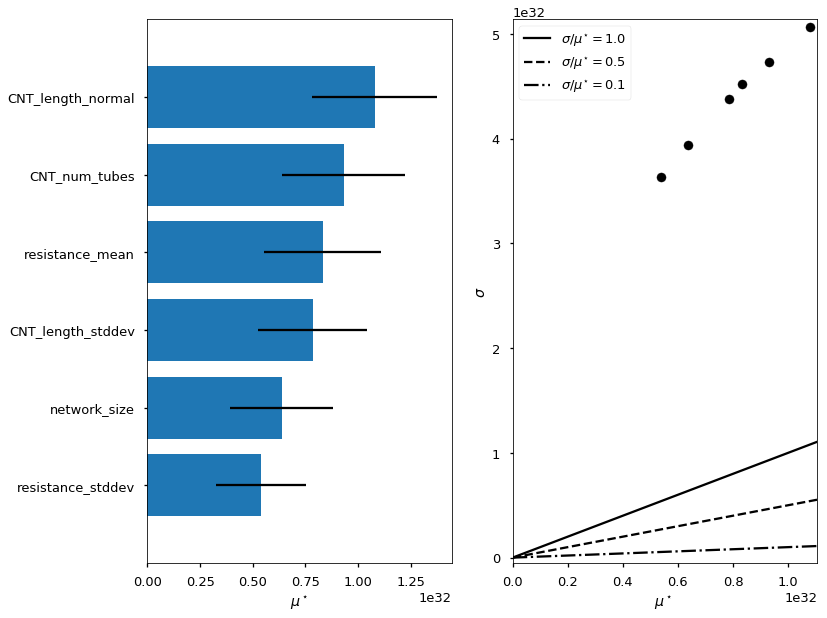

In [115]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, param_dict={})
mp.covariance_plot(ax2, Si, {})
plt.savefig("SA_results_summary.png")

In [99]:
np.max(finite_results)

22773.574732474332

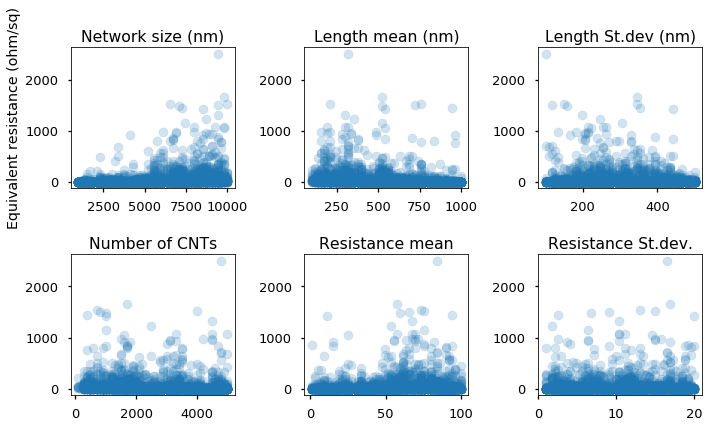

In [128]:
netsize, lenmean, lensd, numtubes, resmean, ressd = finite_parameters.T

#we need to remove one outlier value to make the charts look nice
results_to_plot = finite_results.copy()
results_to_plot[results_to_plot>20000] = np.nan

# Make some scatter plots to compare the results
plt.subplot(231)
plt.scatter(netsize, results_to_plot, alpha=0.2)
plt.title("Network size (nm)")
plt.ylabel("Equivalent resistance (ohm/sq)")

plt.subplot(232)
plt.scatter(lenmean, results_to_plot, alpha=0.2)
plt.title("Length mean (nm)")
#plt.ylabel("Equivalent resistance (ohm/sq)")

plt.subplot(233)
plt.scatter(lensd, results_to_plot, alpha=0.2)
plt.title("Length St.dev (nm)")
#plt.ylabel("Equivalent resistance (ohm/sq)")

plt.subplot(234)
plt.scatter(numtubes, results_to_plot, alpha=0.2)
plt.title("Number of CNTs")
#plt.ylabel("Equivalent resistance (ohm/sq)")

plt.subplot(235)
plt.scatter(resmean, results_to_plot, alpha=0.2)
plt.title("Resistance mean")
#plt.ylabel("Equivalent resistance (ohm/sq)")

plt.subplot(236)
plt.scatter(ressd, results_to_plot, alpha=0.2)
plt.title("Resistance St.dev.")
#plt.ylabel("Equivalent resistance (ohm/sq)")

plt.tight_layout()
plt.savefig('SA_results_scatter.png')


In [122]:
plt.subplot?